In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sc
from ydata_profiling import ProfileReport
from scipy import stats as sts
import sklearn 
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
pd.set_option('display.max_columns', None)
from sklearn.impute import SimpleImputer, KNNImputer
sklearn.impute.KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, fbeta_score, precision_recall_curve, average_precision_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import phik
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
import mlflow
import mlflow.sklearn  # Если нужно логировать модели sklearn
import os
from mlflow.models import infer_signature
import optuna
from fastapi import FastAPI
import mlflow.pyfunc
from pydantic import BaseModel
%matplotlib

Using matplotlib backend: module://matplotlib_inline.backend_inline


In [2]:
mlflow.set_tracking_uri(mlflow.set_tracking_uri("http://192.168.1.104:5000"))
mlflow.set_experiment("client_reliability_exp")

<Experiment: artifact_location='file:///home/vivaldi/MyProjects/ssh_first_try/api_practice/mlruns/110488683877789959', creation_time=1742338155387, experiment_id='110488683877789959', last_update_time=1742338155387, lifecycle_stage='active', name='client_reliability_exp', tags={}>

In [3]:
df_customers = pd.read_csv('/home/vivaldi/MyProjects/ssh_first_try/data/credit-risk/customer_data.csv')
df_payments = pd.read_csv('/home/vivaldi/MyProjects/ssh_first_try/data/credit-risk/payment_data.csv')

In [4]:
df_customers

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11
0,1,54982665,5,1245.5,3,77000.0,2,15,5,109,5,151300,244.948974
1,0,59004779,4,1277.0,1,113000.0,2,8,-1,100,3,341759,207.173840
2,0,58990862,7,1298.0,1,110000.0,2,11,-1,101,5,72001,1.000000
3,1,58995168,7,1335.5,1,151000.0,2,11,5,110,3,60084,1.000000
4,0,54987320,7,NaN,2,59000.0,2,11,5,108,4,450081,197.403141
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,0,58988196,5,1289.0,1,173000.0,2,15,5,112,3,350702,200.000000
1121,0,58987926,5,NaN,2,50000.0,2,15,5,108,4,450000,169.000000
1122,0,58995381,7,1220.0,3,76000.0,2,11,2,90,5,71002,1.000000
1123,0,58998054,4,1250.0,3,137000.0,2,8,5,90,5,72000,1.000000


In [5]:
df_payments

,id,OVD_t1,OVD_t2,OVD_t3,OVD_sum,pay_normal,prod_code,prod_limit,update_date,new_balance,highest_balance,report_date
0,58987402,0,0,0,0,1,10,16500.0,04/12/2016,0.0,NaN,NaN
1,58995151,0,0,0,0,1,5,NaN,04/12/2016,588720.0,491100.0,NaN
2,58997200,0,0,0,0,2,5,NaN,04/12/2016,840000.0,700500.0,22/04/2016
3,54988608,0,0,0,0,3,10,37400.0,03/12/2016,8425.2,7520.0,25/04/2016
4,54987763,0,0,0,0,2,10,NaN,03/12/2016,15147.6,NaN,26/04/2016
...,...,...,...,...,...,...,...,...,...,...,...,...
8245,58995478,0,0,0,0,9,15,NaN,NaN,0.0,NaN,NaN
8246,54992408,0,0,0,0,1,2,NaN,NaN,0.0,NaN,NaN
8247,54988209,0,0,0,0,5,13,NaN,NaN,20654.4,33315.0,NaN
8248,54992408,0,0,0,0,1,2,NaN,NaN,0.0,NaN,NaN


In [6]:
# pr = ProfileReport(df_c, title="Clients")
# pr.to_file("customer_profile_report.html")

# pr2 = ProfileReport(df_p, title="Payments") 
# pr2.to_file("payment_profile_report.html")


In [7]:
df_payments['update_date'].unique()

array(['04/12/2016', '03/12/2016', '02/12/2016', ..., '18/04/1992',
       '19/07/1988', nan], dtype=object)

In [8]:
df_payments['update_date'] = pd.to_datetime(df_payments['update_date'], format='%d/%m/%Y')
df_payments['report_date'] = pd.to_datetime(df_payments['update_date'], format='%d/%m/%Y')



In [9]:
df_payments.dtypes

id                          int64
OVD_t1                      int64
OVD_t2                      int64
OVD_t3                      int64
OVD_sum                     int64
pay_normal                  int64
prod_code                   int64
prod_limit                float64
update_date        datetime64[ns]
new_balance               float64
highest_balance           float64
report_date        datetime64[ns]
dtype: object

In [10]:
grouped = df_payments.groupby('id').agg({
    'OVD_t1': ['mean', 'max'],
    'OVD_t2': ['mean', 'max'],
    'OVD_t3': ['mean', 'max'],
    'pay_normal': ['mean', 'max'],
    'prod_code': 'median',
    'update_date': 'mean',
    'report_date': 'mean',
    'prod_limit': 'mean',
    'new_balance': 'mean',
    'highest_balance': 'mean'
})

grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]
grouped = grouped.reset_index()
grouped

,id,OVD_t1_mean,OVD_t1_max,OVD_t2_mean,OVD_t2_max,OVD_t3_mean,OVD_t3_max,pay_normal_mean,pay_normal_max,prod_code_median,update_date_mean,report_date_mean,prod_limit_mean,new_balance_mean,highest_balance_mean
0,54982353,0.166667,1,0.111111,2,2.111111,35,12.722222,35,10.0,2005-09-29 22:40:00.000000000,2005-09-29 22:40:00.000000000,259600.0,42033.133333,246583.714286
1,54982356,0.000000,0,0.000000,0,0.000000,0,16.714286,36,10.0,2002-08-21 00:00:00.000000000,2002-08-21 00:00:00.000000000,330000.0,2277.771429,196649.285714
2,54982387,0.272727,2,0.000000,0,0.000000,0,22.363636,36,6.0,2012-02-23 04:21:49.090909184,2012-02-23 04:21:49.090909184,109450.0,117455.127273,238270.000000
3,54982463,0.000000,0,0.000000,0,0.000000,0,17.000000,19,9.0,2013-03-02 12:00:00.000000000,2013-03-02 12:00:00.000000000,NaN,39890.400000,78500.000000
4,54982530,0.000000,0,0.000000,0,0.000000,0,14.000000,25,10.0,2014-08-18 00:00:00.000000000,2014-08-18 00:00:00.000000000,94600.0,1261.200000,12787.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,59005995,0.000000,0,0.000000,0,0.000000,0,16.333333,27,10.0,2015-01-19 00:00:00.000000000,2015-01-19 00:00:00.000000000,35200.0,57099.600000,105173.666667
1121,59006139,0.000000,0,0.000000,0,0.000000,0,7.250000,20,5.5,2015-09-21 18:00:00.000000000,2015-09-21 18:00:00.000000000,59400.0,14652.300000,49595.750000
1122,59006193,0.000000,0,0.000000,0,0.000000,0,13.250000,33,10.0,2014-08-17 00:00:00.000000000,2014-08-17 00:00:00.000000000,105160.0,13651.350000,50328.625000
1123,59006219,0.333333,1,0.000000,0,0.000000,0,27.000000,36,10.0,2013-10-20 08:00:00.000000000,2013-10-20 08:00:00.000000000,33000.0,179909.200000,189248.666667


In [11]:
grouped = round(grouped, 2)

In [12]:
grouped['update_date_mean'] = grouped['update_date_mean'].dt.floor('d')
grouped['report_date_mean'] = grouped['report_date_mean'].dt.floor('d')

In [13]:
grouped

,id,OVD_t1_mean,OVD_t1_max,OVD_t2_mean,OVD_t2_max,OVD_t3_mean,OVD_t3_max,pay_normal_mean,pay_normal_max,prod_code_median,update_date_mean,report_date_mean,prod_limit_mean,new_balance_mean,highest_balance_mean
0,54982353,0.17,1,0.11,2,2.11,35,12.72,35,10.0,2005-09-29,2005-09-29,259600.0,42033.13,246583.71
1,54982356,0.00,0,0.00,0,0.00,0,16.71,36,10.0,2002-08-21,2002-08-21,330000.0,2277.77,196649.29
2,54982387,0.27,2,0.00,0,0.00,0,22.36,36,6.0,2012-02-23,2012-02-23,109450.0,117455.13,238270.00
3,54982463,0.00,0,0.00,0,0.00,0,17.00,19,9.0,2013-03-02,2013-03-02,NaN,39890.40,78500.00
4,54982530,0.00,0,0.00,0,0.00,0,14.00,25,10.0,2014-08-18,2014-08-18,94600.0,1261.20,12787.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,59005995,0.00,0,0.00,0,0.00,0,16.33,27,10.0,2015-01-19,2015-01-19,35200.0,57099.60,105173.67
1121,59006139,0.00,0,0.00,0,0.00,0,7.25,20,5.5,2015-09-21,2015-09-21,59400.0,14652.30,49595.75
1122,59006193,0.00,0,0.00,0,0.00,0,13.25,33,10.0,2014-08-17,2014-08-17,105160.0,13651.35,50328.62
1123,59006219,0.33,1,0.00,0,0.00,0,27.00,36,10.0,2013-10-20,2013-10-20,33000.0,179909.20,189248.67


In [14]:
df_customers

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11
0,1,54982665,5,1245.5,3,77000.0,2,15,5,109,5,151300,244.948974
1,0,59004779,4,1277.0,1,113000.0,2,8,-1,100,3,341759,207.173840
2,0,58990862,7,1298.0,1,110000.0,2,11,-1,101,5,72001,1.000000
3,1,58995168,7,1335.5,1,151000.0,2,11,5,110,3,60084,1.000000
4,0,54987320,7,NaN,2,59000.0,2,11,5,108,4,450081,197.403141
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,0,58988196,5,1289.0,1,173000.0,2,15,5,112,3,350702,200.000000
1121,0,58987926,5,NaN,2,50000.0,2,15,5,108,4,450000,169.000000
1122,0,58995381,7,1220.0,3,76000.0,2,11,2,90,5,71002,1.000000
1123,0,58998054,4,1250.0,3,137000.0,2,8,5,90,5,72000,1.000000


In [15]:
df_customers.dtypes

label       int64
id          int64
fea_1       int64
fea_2     float64
fea_3       int64
fea_4     float64
fea_5       int64
fea_6       int64
fea_7       int64
fea_8       int64
fea_9       int64
fea_10      int64
fea_11    float64
dtype: object

In [16]:
df = df_customers.merge(grouped, on='id')

In [17]:
df[df.index == 2]

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11,OVD_t1_mean,OVD_t1_max,OVD_t2_mean,OVD_t2_max,OVD_t3_mean,OVD_t3_max,pay_normal_mean,pay_normal_max,prod_code_median,update_date_mean,report_date_mean,prod_limit_mean,new_balance_mean,highest_balance_mean
2,0,58990862,7,1298.0,1,110000.0,2,11,-1,101,5,72001,1.0,0.0,0,0.0,0,0.0,0,10.67,23,7.5,2015-03-15,2015-03-15,102300.0,109178.8,118865.67


In [18]:
np.array(df)

array([[1, 54982665, 5, ..., 60500.0, 40112.4, 91298.0],
       [0, 59004779, 4, ..., 69666.67, 2040.48, 74837.0],
       [0, 58990862, 7, ..., 102300.0, 109178.8, 118865.67],
       ...,
       [0, 58995381, 7, ..., nan, 79084.35, 94077.12],
       [0, 58998054, 4, ..., 69575.0, 21323.85, 127470.0],
       [0, 54989781, 4, ..., nan, 266206.8, 947862.33]], dtype=object)

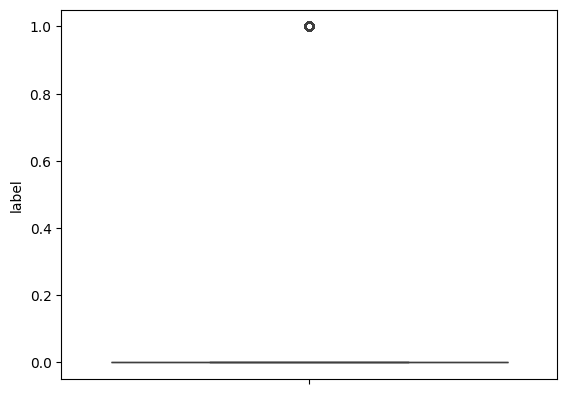

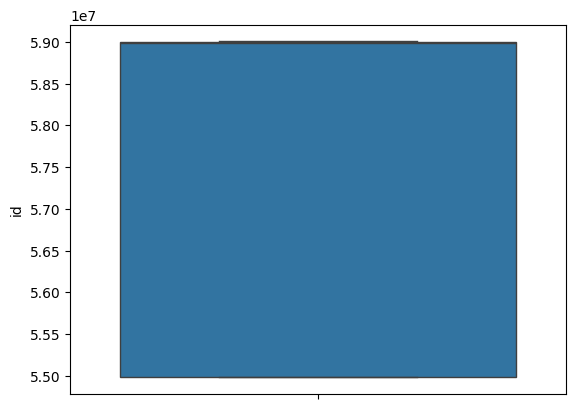

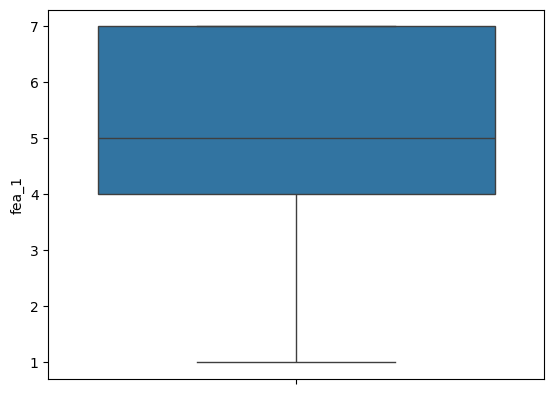

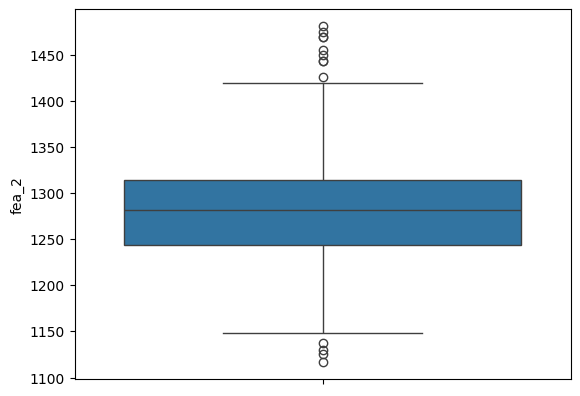

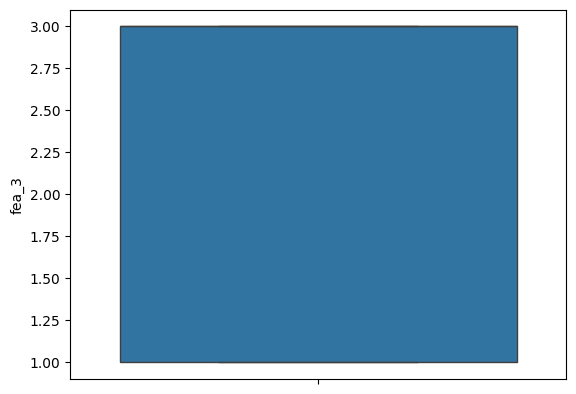

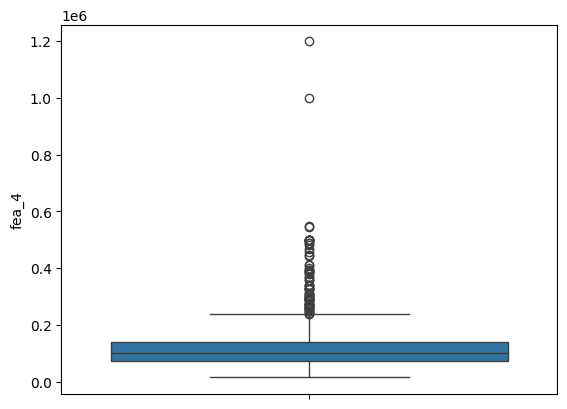

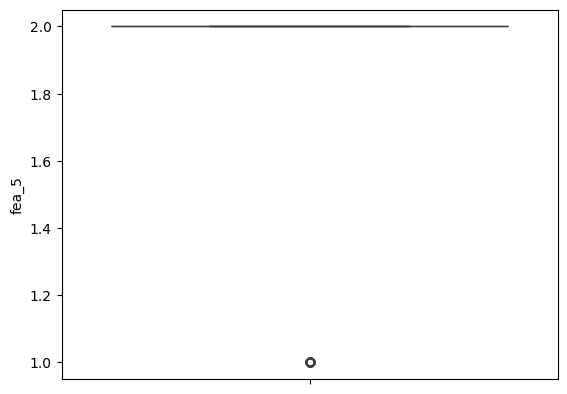

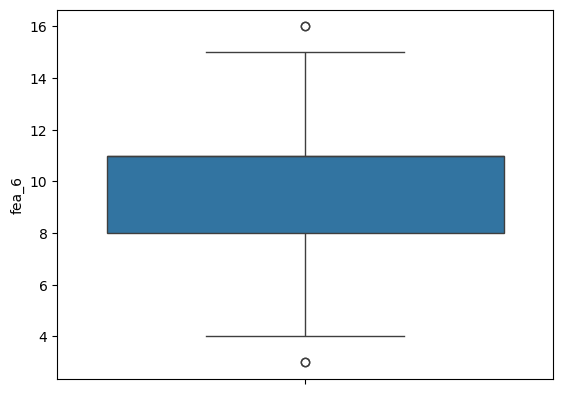

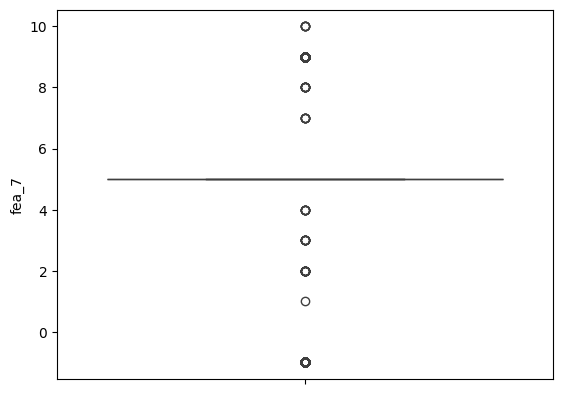

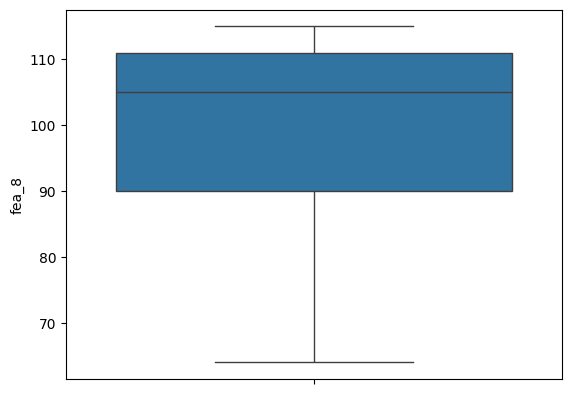

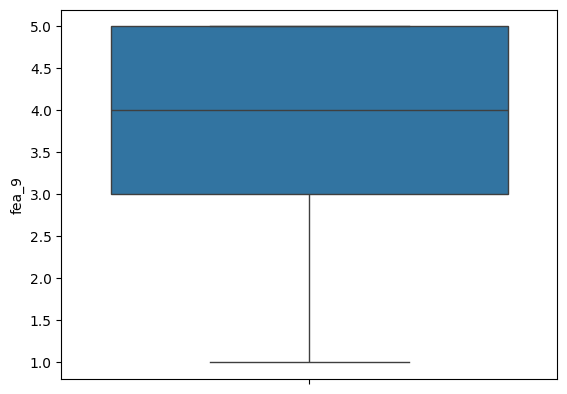

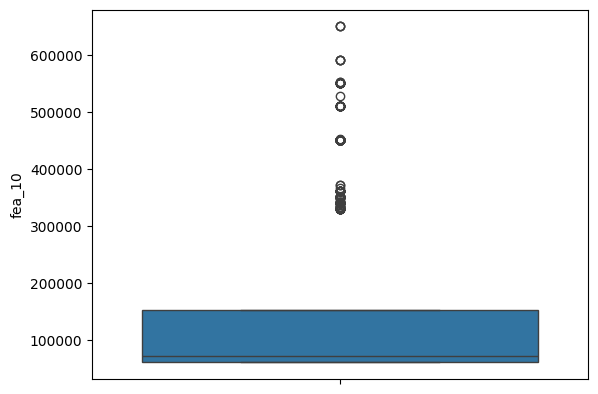

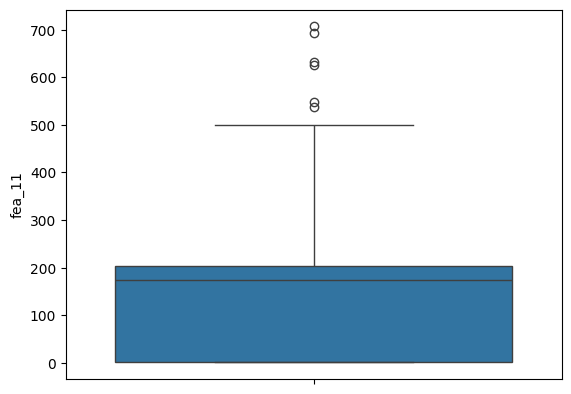

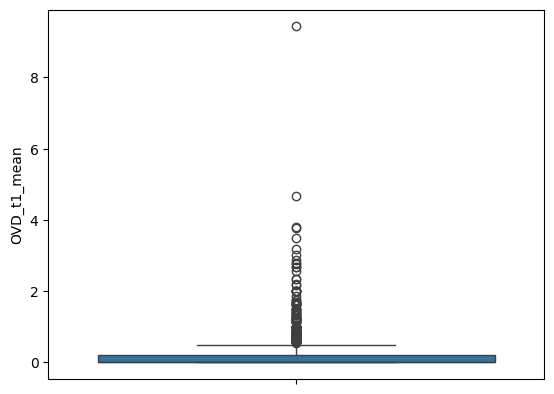

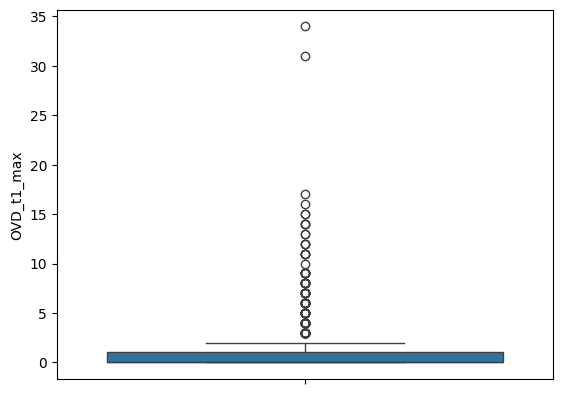

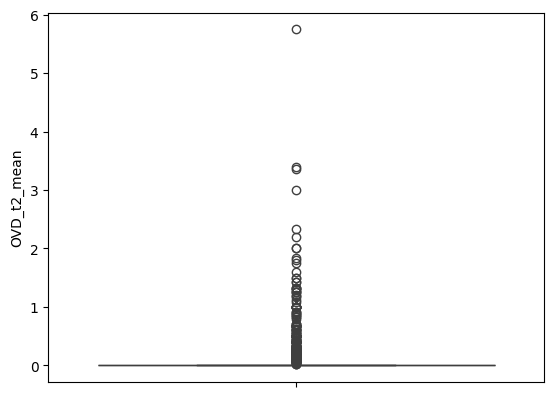

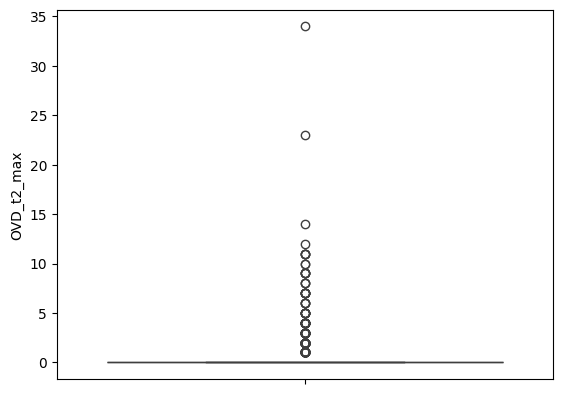

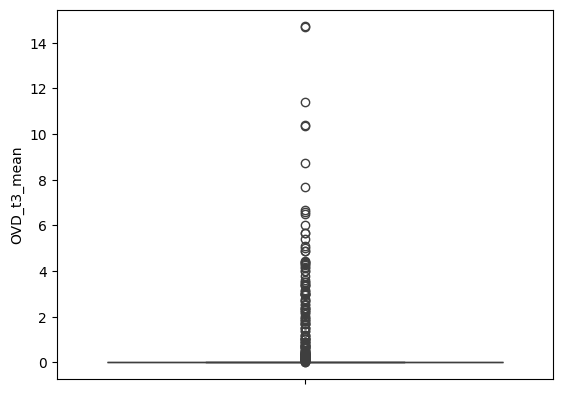

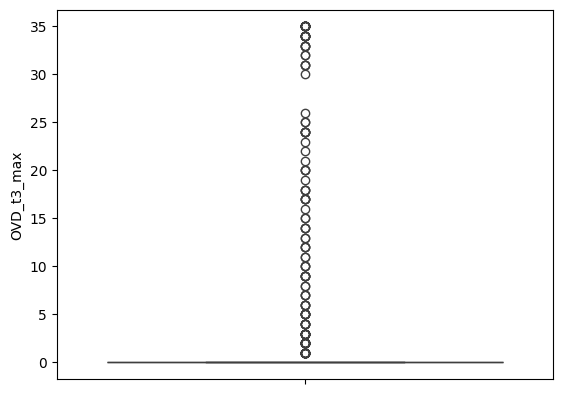

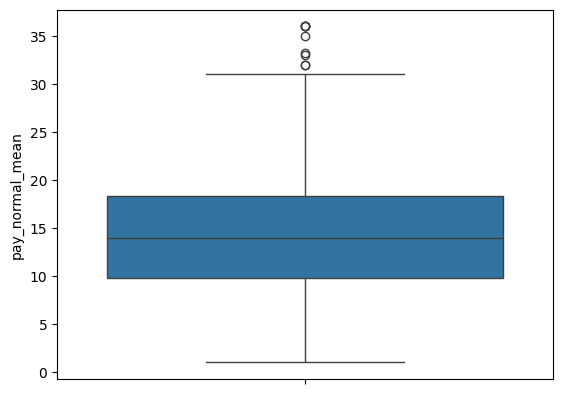

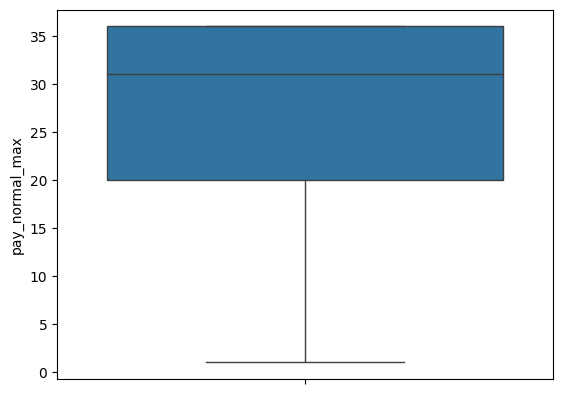

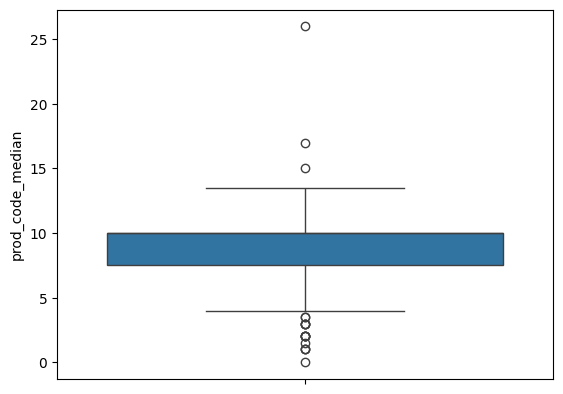

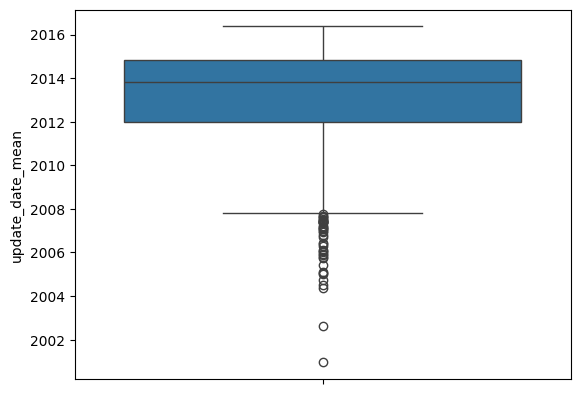

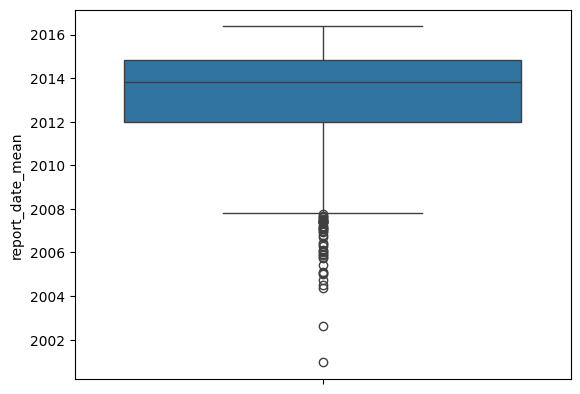

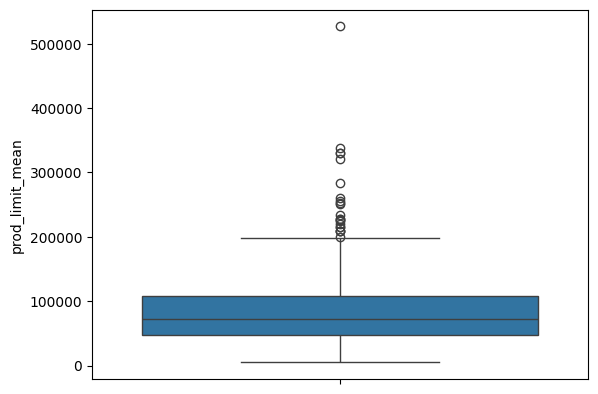

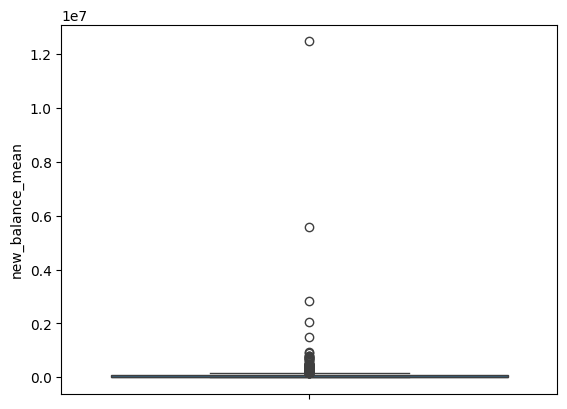

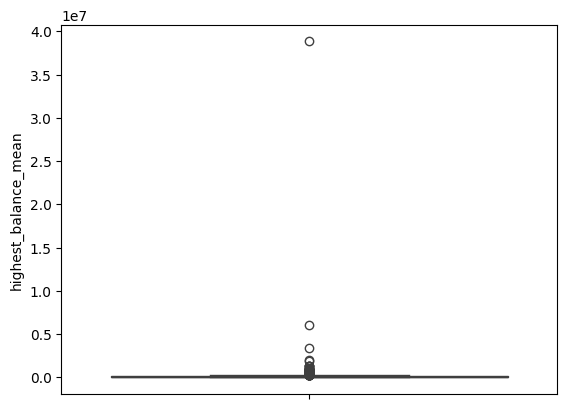

In [19]:
for i in df.columns:
    sns.boxplot(df[i])
    plt.show()

In [20]:
df['update_date_mean'] = (df['update_date_mean'] - df['update_date_mean'].min()).dt.days
df['report_date_mean'] = (df['report_date_mean'] - df['report_date_mean'].min()).dt.days

In [21]:
df[df['highest_balance_mean'] == df['highest_balance_mean'].max()]

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11,OVD_t1_mean,OVD_t1_max,OVD_t2_mean,OVD_t2_max,OVD_t3_mean,OVD_t3_max,pay_normal_mean,pay_normal_max,prod_code_median,update_date_mean,report_date_mean,prod_limit_mean,new_balance_mean,highest_balance_mean
103,1,58989344,7,1265.0,3,70000.0,2,11,-1,81,5,350704,316.227766,1.27,7,0.4,3,0.0,0,16.53,36,3.0,3415,3415,143000.0,12475780.4,38846604.31


In [22]:
X = df.drop(columns='label')
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

In [23]:
y_test.to_csv('y_test.csv', index=False)


In [24]:
X_train

,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11,OVD_t1_mean,OVD_t1_max,OVD_t2_mean,OVD_t2_max,OVD_t3_mean,OVD_t3_max,pay_normal_mean,pay_normal_max,prod_code_median,update_date_mean,report_date_mean,prod_limit_mean,new_balance_mean,highest_balance_mean
829,54991669,4,NaN,2,41000.0,2,8,5,110,3,60036,164.185870,0.33,2,0.00,0,0.00,0,18.17,34,6.0,3946,3946,91300.0,244279.60,255748.33
14,58992002,7,1365.5,1,96000.0,2,11,-1,78,3,60025,178.885438,0.83,8,0.67,5,0.11,2,6.28,18,10.0,3242,3242,NaN,4842.87,66337.67
1105,59004235,4,NaN,2,150000.0,2,8,5,100,3,60018,244.754979,1.40,9,1.30,7,1.50,14,10.60,36,10.0,3516,3516,NaN,15714.96,41576.60
684,58990258,7,NaN,2,69000.0,1,11,5,106,4,60064,173.205081,0.00,0,0.00,0,0.00,0,5.00,9,10.0,5335,5335,77000.0,54115.80,62095.00
880,58997856,4,NaN,2,65000.0,2,8,9,112,5,72001,206.661559,0.00,0,0.00,0,0.00,0,14.33,29,7.5,5083,5083,45100.0,57826.40,79416.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,54988522,7,1214.0,3,58000.0,2,11,5,110,4,151300,158.113883,0.00,0,0.00,0,0.00,0,5.00,8,10.0,5448,5448,39600.0,13629.60,12399.00
352,58988250,5,1242.5,3,30000.0,2,15,5,80,3,60050,200.000000,0.00,0,0.00,0,0.00,0,15.86,35,6.0,4774,4774,55000.0,256105.89,286555.57
817,54985929,7,NaN,2,73000.0,2,11,9,114,4,361000,153.391656,3.00,5,0.33,1,0.33,1,24.00,35,6.0,4152,4152,NaN,119571.20,198522.67
642,59005871,4,1356.5,1,136000.0,2,8,5,74,3,72000,1.000000,0.00,0,0.00,0,0.00,0,22.40,36,6.0,3752,3752,34100.0,13757.52,121974.20


In [25]:
X_test

,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11,OVD_t1_mean,OVD_t1_max,OVD_t2_mean,OVD_t2_max,OVD_t3_mean,OVD_t3_max,pay_normal_mean,pay_normal_max,prod_code_median,update_date_mean,report_date_mean,prod_limit_mean,new_balance_mean,highest_balance_mean
740,54983623,5,1353.5,3,143000.0,2,15,5,110,4,60007,1.000000,0.00,0,0.0,0,0.0,0,15.57,36,10.0,4539,4539,77550.00,85885.89,158164.29
57,59004654,4,1352.0,1,168000.0,2,8,5,105,3,60017,223.606798,0.00,0,0.0,0,0.0,0,10.83,26,6.0,5344,5344,129800.00,35898.80,95626.33
483,58984737,5,1292.0,3,130000.0,2,15,2,111,4,71000,173.205081,0.25,1,0.0,0,0.0,0,14.50,35,8.0,4698,4698,118800.00,22752.60,54203.75
646,54985058,7,1266.5,3,227000.0,2,11,9,112,4,151300,254.950976,0.00,0,0.0,0,0.0,0,11.09,32,10.0,4686,4686,155283.33,9477.27,55803.62
4,54987320,7,NaN,2,59000.0,2,11,5,108,4,450081,197.403141,0.00,0,0.0,0,0.0,0,21.44,36,10.0,4265,4265,154733.33,260363.33,395634.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,58984428,5,1304.0,3,140000.0,2,15,5,80,3,151300,187.082869,0.00,0,0.0,0,0.0,0,16.60,36,10.0,3778,3778,94600.00,900.48,79258.80
36,58994549,7,NaN,2,90000.0,2,11,2,114,4,151300,173.205081,0.00,0,0.0,0,0.0,0,17.00,26,2.0,4756,4756,NaN,431352.40,384189.00
308,58992602,7,1368.5,3,390000.0,2,11,5,101,5,60024,173.205081,0.17,1,0.0,0,0.0,0,11.33,28,10.0,4185,4185,135850.00,1950.60,275348.67
753,54991614,4,1266.5,3,101000.0,2,8,9,101,4,60084,1.000000,0.00,0,0.0,0,0.0,0,7.50,12,10.0,5382,5382,106700.00,13554.00,23557.00


In [27]:
list(X_test.columns)

['id',
 'fea_1',
 'fea_2',
 'fea_3',
 'fea_4',
 'fea_5',
 'fea_6',
 'fea_7',
 'fea_8',
 'fea_9',
 'fea_10',
 'fea_11',
 'OVD_t1_mean',
 'OVD_t1_max',
 'OVD_t2_mean',
 'OVD_t2_max',
 'OVD_t3_mean',
 'OVD_t3_max',
 'pay_normal_mean',
 'pay_normal_max',
 'prod_code_median',
 'update_date_mean',
 'report_date_mean',
 'prod_limit_mean',
 'new_balance_mean',
 'highest_balance_mean']

In [49]:
pd.DataFrame(y_test)

,label
1059,0
43,0
574,0
585,0
801,0
...,...
905,1
272,1
531,0
567,0


In [61]:
y_test.iloc[1].dtype

dtype('int64')

In [63]:
X_test.dtypes

id                        int64
fea_1                     int64
fea_2                   float64
fea_3                     int64
fea_4                   float64
fea_5                     int64
fea_6                     int64
fea_7                     int64
fea_8                     int64
fea_9                     int64
fea_10                    int64
fea_11                  float64
OVD_t1_mean             float64
OVD_t1_max                int64
OVD_t2_mean             float64
OVD_t2_max                int64
OVD_t3_mean             float64
OVD_t3_max                int64
pay_normal_mean         float64
pay_normal_max            int64
prod_code_median        float64
update_date_mean          int64
report_date_mean          int64
prod_limit_mean         float64
new_balance_mean        float64
highest_balance_mean    float64
dtype: object

In [18]:
def create_pipeline(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 3, 10)
    model = trial.suggest_categorical('model', ['lgbm', 'catboost', 'xgbm'])
    
    if model == 'lgbm':
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
        num_leaves = trial.suggest_int('num_leaves', 20, 100)
        min_child_samples = trial.suggest_int('min_child_samples', 5, 30)
        classifier = LGBMClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            min_child_samples=min_child_samples,
            subsample=trial.suggest_float('subsample', 0.5, 1.0),
            colsample_bytree=trial.suggest_float('colsample_bytree', 0.5, 1.0),
            reg_alpha=trial.suggest_float('reg_alpha', 0.0, 5.0),
            reg_lambda=trial.suggest_float('reg_lambda', 0.0, 5.0),
            min_split_gain=trial.suggest_float('min_split_gain', 0.0, 1.0),
            min_child_weight=trial.suggest_float('min_child_weight', 1e-3, 10.0),
            random_state=42
        )
    elif model == 'catboost':
        depth = trial.suggest_int('depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
        l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1, 10)
        classifier = CatBoostClassifier(
            depth=depth,
            learning_rate=learning_rate,
            l2_leaf_reg=l2_leaf_reg,
            random_state=42
        )
        
    else:
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
        min_child_weight = trial.suggest_float('min_child_weight', 1.0, 7.0)  # Consistent float distribution
        subsample = trial.suggest_float('subsample', 0.5, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
        gamma = trial.suggest_float('gamma', 0, 5)
        reg_alpha = trial.suggest_float('reg_alpha', 0, 5) 
        reg_lambda = trial.suggest_float('reg_lambda', 0, 5)
        classifier = XGBClassifier(
                                   max_depth=max_depth,
                                   learning_rate=learning_rate,
                                   min_child_weight=min_child_weight,
                                   subsample=subsample,
                                   colsample_bytree=colsample_bytree,
                                   gamma=gamma,
                                   reg_alpha=reg_alpha,
                                   reg_lambda=reg_lambda,
                                   random_state=42
                                   )
        
    pipeline = Pipeline([
        ('imputer', KNNImputer(n_neighbors=n_neighbors)),
        ('scaler', PowerTransformer()),
        ('model', classifier)
    ])
    
    return pipeline
        
        
def objective(trial):
    pipeline_opt = create_pipeline(trial)
    
    pipeline_opt.fit(X_train, y_train)
    predictions = pipeline_opt.predict(X_test)
    
    metric = f1_score(y_test, predictions, average='weighted')
    
    return metric

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
best_trial = study.best_trial
best_pipeline = create_pipeline(best_trial)

mlflow.set_tracking_uri(mlflow.set_tracking_uri("http://192.168.1.104:5000"))
mlflow.set_experiment("client_reliability_exp")

with mlflow.start_run():
    mlflow.log_params(best_trial.params)
    
    best_pipeline.fit(X_train, y_train)
    predictions = best_pipeline.predict(X_test)
    prob = best_pipeline.predict_proba(X_test)
    
    f1 = f1_score(y_test, predictions, average='weighted')
    accuracy = accuracy_score(y_test, predictions)
    recall, precision, _ = precision_recall_curve(y_test, prob[:, 1])
    fpr, tpr, thresholds = roc_curve(y_test, prob[:, 1])
    fbeta = fbeta_score(y_test, predictions, beta=1.5)
    b_acc = balanced_accuracy_score(y_test, predictions)
    
    mlflow.log_metrics({
    "f1": f1,
    "accuracy": accuracy,
    'fbeta': fbeta,
    'balanced_accuracy': b_acc
    })
    mlflow.log_metric("Best Objective Value", study.best_value)
    
    example_input = X_test[:5]
    signature = infer_signature(X_test, best_pipeline.predict(X_test))
    mlflow.sklearn.log_model(best_pipeline, "model_pipeline", signature=signature, input_example=example_input)
    
    # Create and log PR curve
    plt.figure()
    plt.plot(recall, precision)
    plt.title('Best Model PR-curve')
    mlflow.log_figure(plt.gcf(), "pr_curve.png")
    plt.close()
    
    # Create and log ROC curve 
    plt.figure()
    plt.plot(fpr, tpr)
    plt.title('Best Model ROC-curve')
    mlflow.log_figure(plt.gcf(), "roc_curve.png")
    plt.close()


    

[I 2025-03-18 22:21:01,466] A new study created in memory with name: no-name-d8e2c7f2-bbce-4889-819d-49f02b8e6ec7
[W 2025-03-18 22:21:01,468] Trial 0 failed with parameters: {'n_neighbors': 7, 'model': 'xgbm', 'max_depth': 7, 'learning_rate': 0.041050908988497524, 'min_child_weight': 3.4376412843894544, 'subsample': 0.543839835418904, 'colsample_bytree': 0.5118767584655832, 'gamma': 0.6588285810894207, 'reg_alpha': 0.9310806673656219, 'reg_lambda': 3.940330319582995} because of the following error: NameError("name 'X_train' is not defined").
Traceback (most recent call last):
  File "/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_21112/1085770272.py", line 69, in objective
    pipeline_opt.fit(X_train, y_train)
NameError: name 'X_train' is not defined
[W 2025-03-18 22:21:01,469] Trial 0 failed with value None.


NameError: name 'X_train' is not defined

In [43]:
import re
pattern = r'\D'
for i, j in dict(X_test.dtypes).items():
    nonum = ''.join(re.findall(pattern, str(j)))
    print(f"{i}: {nonum}")

id: int
fea_1: int
fea_2: float
fea_3: int
fea_4: float
fea_5: int
fea_6: int
fea_7: int
fea_8: int
fea_9: int
fea_10: int
fea_11: float
OVD_t1_mean: float
OVD_t1_max: int
OVD_t2_mean: float
OVD_t2_max: int
OVD_t3_mean: float
OVD_t3_max: int
pay_normal_mean: float
pay_normal_max: int
prod_code_median: float
update_date_mean: int
report_date_mean: int
prod_limit_mean: float
new_balance_mean: float
highest_balance_mean: float


In [47]:
model = mlflow.pyfunc.load_model(f"models:/CatBoostClassifier/latest")

app = FastAPI()

class ModelInput(BaseModel):
    id: int
    fea_1: int
    fea_2: float
    fea_3: int
    fea_4: float
    fea_5: int
    fea_6: int
    fea_7: int
    fea_8: int
    fea_9: int
    fea_10: int
    fea_11: float
    OVD_t1_mean: float
    OVD_t1_max: int
    OVD_t2_mean: float
    OVD_t2_max: int
    OVD_t3_mean: float
    OVD_t3_max: int
    pay_normal_mean: float
    pay_normal_max: int
    prod_code_median: float
    update_date_mean: int
    report_date_mean: int
    prod_limit_mean: float
    new_balance_mean: float
    highest_balance_mean: float
    

@app.post("/predict/")
def predict(input_data: ModelInput):
    # Convert input data to the format expected by the model
    input_dict = input_data.dict()
    input_list = [list(input_dict.values())]  # Convert dict to list
    prediction = model.predict(input_list)

    return {"prediction": prediction.tolist()}
    

/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/mlflow/store/artifact/utils/models.py:31: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


In [58]:
# Access the imputer and scaler from the best pipeline
imputer = best_pipeline.named_steps['imputer']
scaler = best_pipeline.named_steps['scaler']

# Apply the imputer and scaler to X_test
X_test1 = imputer.transform(X_test)
X_test1 = scaler.transform(X_test1)
X_test1

array([[ 0.64448625, -1.07065425,  0.71043406, ..., -1.80958957,
        -0.39956816, -1.13995912],
       [ 0.6465096 , -1.07065425, -1.02562848, ..., -0.96437486,
        -0.41526053, -1.15896423],
       [-1.57121527,  1.10126014,  0.99089429, ..., -0.31823458,
        -0.38366805, -0.50872216],
       ...,
       [-1.57253156, -0.34933414, -0.81876088, ...,  0.84229931,
         0.42288236,  1.53395123],
       [ 0.64514404, -1.07065425,  0.08198332, ..., -2.67092454,
        -0.59444735, -1.46028406],
       [ 0.63700679,  1.10126014,  0.2103016 , ...,  0.54858938,
         1.52293558,  1.52120131]])

In [60]:
X_test1 = pd.DataFrame(X_test1, columns=X_test.columns)
X_test1

,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11,OVD_t1_mean,OVD_t1_max,OVD_t2_mean,OVD_t2_max,OVD_t3_mean,OVD_t3_max,pay_normal_mean,pay_normal_max,prod_code_median,update_date_mean,report_date_mean,prod_limit_mean,new_balance_mean,highest_balance_mean
0,0.644486,-1.070654,0.710434,0.799923,-0.207119,0.296901,-1.081261,-0.013128,0.936624,-0.352030,0.648061,-1.295666,-0.718713,-0.762705,-0.488491,-0.498419,-0.381707,-0.395445,-1.362329,-1.659268,1.295832,1.663254,1.663254,-1.809590,-0.399568,-1.139959
1,0.646510,-1.070654,-1.025628,-1.430127,-0.714396,0.296901,-1.081261,-0.013128,-1.713236,-0.352030,-0.526533,-1.295666,-0.718713,-0.762705,-0.488491,-0.498419,-0.381707,-0.395445,0.241639,0.375030,-0.485009,0.412335,0.412335,-0.964375,-0.415261,-1.158964
2,-1.571215,1.101260,0.990894,-1.430127,0.253096,0.296901,0.132390,-1.853371,-1.258962,-1.347391,1.315598,0.451621,1.002311,1.298278,-0.488491,-0.498419,-0.381707,-0.395445,-0.075212,0.956895,-1.417224,-0.450912,-0.450912,-0.318235,-0.383668,-0.508722
3,0.632511,1.101260,-0.750830,0.799923,0.465663,0.296901,0.132390,-0.013128,-0.452983,1.018562,1.454998,1.020863,-0.718713,-0.762705,-0.488491,-0.498419,-0.381707,-0.395445,1.429212,0.956895,0.511497,-1.712956,-1.712956,2.048988,0.068065,0.441337
4,0.641708,-1.070654,-0.983882,-0.634411,-1.452929,0.296901,-1.081261,1.507718,1.354062,-0.352030,-0.948840,0.617171,-0.718713,-0.762705,-0.488491,-0.498419,-0.381707,-0.395445,-0.648694,-1.437412,0.511497,0.954324,0.954324,-0.840247,-0.213564,-0.591978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,-1.571034,-1.070654,-0.656573,-0.634411,-1.169404,0.296901,-1.081261,-0.013128,-1.092229,1.018562,-0.526087,0.677912,-0.718713,-0.762705,-0.488491,-0.498419,-0.381707,-0.395445,-1.784577,-1.745198,0.511497,1.490075,1.490075,-0.880778,0.744074,0.872978
368,-1.570999,-1.070654,0.179925,0.799923,0.125818,0.296901,-1.081261,1.507718,1.354062,-0.352030,-0.947049,0.720737,-0.718713,-0.762705,-0.488491,-0.498419,-0.381707,-0.395445,-1.251227,-1.499103,0.511497,1.228234,1.228234,0.704836,-0.505484,-2.168608
369,-1.572532,-0.349334,-0.818761,0.799923,-2.079599,0.296901,1.472568,-0.013128,0.110582,1.018562,0.650248,0.886620,0.732034,0.875321,-0.488491,-0.498419,-0.381707,-0.395445,0.267365,0.956895,-1.855516,-0.184709,-0.184709,0.842299,0.422882,1.533951
370,0.645144,-1.070654,0.081983,-0.634411,-0.381792,-3.368124,-1.081261,1.507718,-0.278584,1.018562,-0.526562,0.722424,-0.718713,-0.762705,-0.488491,-0.498419,-0.381707,-0.395445,-0.838949,-0.376126,0.511497,-1.785922,-1.785922,-2.670925,-0.594447,-1.460284


In [63]:
X_test1.to_csv('X_test.csv', index=False)

In [61]:
import requests

url = "http://192.168.1.104:8000/predict/"

response = requests.post(url, json=X_test1.to_dict())
print(response.json())

ConnectionError: HTTPConnectionPool(host='192.168.1.104', port=8000): Max retries exceeded with url: /predict/ (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f6d0ce8a320>: Failed to establish a new connection: [Errno 111] Connection refused'))

In [ ]:
uvicorn test_api:app --host 192.168.1.104 --port 8000
    

In [57]:
model_uri = "models:/CatBoostClassifier/2"  # Change to your actual model URI
model_info = mlflow.models.get_model_info(model_uri)

print(model_info.flavors)

{'python_function': {'env': {'conda': 'conda.yaml', 'virtualenv': 'python_env.yaml'}, 'loader_module': 'mlflow.sklearn', 'model_path': 'model.pkl', 'predict_fn': 'predict', 'python_version': '3.10.16'}, 'sklearn': {'code': None, 'pickled_model': 'model.pkl', 'serialization_format': 'cloudpickle', 'sklearn_version': '1.6.1'}}
